#### Introduction

Sri Lanka, renowned for its natural beauty, cultural heritage, and hospitality, is working to reestablish itself as a leading tourist destination in Asia. In the digital age, platforms like TripAdvisor play a critical role in shaping travelers’ perceptions, as hotel reviews offer direct insights into guest experiences. This project aims to leverage large-scale user-generated content from TripAdvisor specifically, at least 5,000 reviews from over 100 Sri Lankan hotels to analyze sentiment trends, extract meaningful aspects of service, and ultimately support tourism promotion with data-driven insights.

The project is structured into six interconnected tasks, progressing from data collection and cleaning, to sentiment labelling using ensemble methods, through feature engineering and text classification, and culminating in aspect-based sentiment analysis via topic modelling. I begin by describing and exploring the dataset, then establish a "ground truth" sentiment through multiple classifiers and majority voting. This is followed by generating sparse and dense vector representations and testing three distinct machine learning algorithms for sentiment prediction. I then compare these results to models built using pre-trained contextual embeddings and deep learning architectures. Finally, I perform unsupervised topic modelling to identify hotel service aspects, validate them against manual labels, and implement an aspect-based sentiment classifier. Through this pipeline, the project not only evaluates multiple natural language processing (NLP) strategies but also highlights the strengths and limitations of unsupervised clustering for real-world tourism data.

#### Oblective

The aim of this project is to apply a full natural language processing (NLP) pipeline to large-scale hotel review data from Sri Lanka in order to:

- Extract actionable insights about customer sentiment and service aspects from unstructured text.
- Compare multiple sentiment analysis approaches from lexicon-based to machine learning to deep learning using both handcrafted and pre-trained embeddings.
- Identify hotel service aspects through unsupervised topic modelling and evaluate how well these clusters align with human interpretation.
- Demonstrate practical NLP skills including text cleaning, feature extraction, classification, clustering, and evaluation with real-world tourism data.

### 01- Importing Required Libraries

In [1]:
from glob import glob
import os
import random

import numpy as np
from numpy import mean, zeros
import pandas as pd
from collections import Counter
import scipy.stats as stats
from sklearn.pipeline import Pipeline

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

from wordcloud import WordCloud, STOPWORDS
import squarify
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
sns.set(style='ticks')
%matplotlib inline

import time
from time import perf_counter

import re

import spacy
nlp = spacy.load("en_core_web_sm")

from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api
from gensim.models import KeyedVectors

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    precision_recall_curve,
    average_precision_score)
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, jaccard_score
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import linear_sum_assignment

# Download necessary NLTK data
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize, casual_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Download pretrained Word2Vec
w2v = api.load("word2vec-google-news-300")
# Save the model
w2v.save("word2vec_google_news_300.model")

from transformers import pipeline, BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from bertopic import BERTopic
from datasets import Dataset
import torch
from tqdm import tqdm

from hdbscan import HDBSCAN
from umap import UMAP
from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading p

---

### 02- Importing Web Scrapped Data 

- I began by gathering multiple TripAdvisor hotel review datasets from the provided folder and sorted them to maintain a consistent order. Then carefully checked the files to identify the columns that were common across all datasets, ensuring that only consistent and comparable information was kept. After filtering each dataset was merged into a single, unified dataset.

In [2]:
folder_path = '/kaggle/input/tripadvisor'
filenames = sorted(glob(os.path.join(folder_path, 'dataset_tripadvisor-reviews-scraper-task_*.csv')))
dfs = [pd.read_csv(f) for f in filenames]

In [3]:
# Keep only common columns
common_cols = set(dfs[0].columns)
for df in dfs[1:]:
    common_cols &= set(df.columns)

# Filter all DataFrames to keep only common columns
dfs = [df[list(common_cols)] for df in dfs]

# Combine them into one
raw_df = pd.concat(dfs, ignore_index=True)
raw_df

,user/avatar,ownerResponse/lang,photos/10/height,photos/12/image,helpfulVotes,photos/16/id,photos/0/height,photos/20/width,user/avatar/width,photos/21/id,...,placeInfo/addressObj/postalcode,photos/5/height,photos/13/id,ownerResponse/publishedDate,photos/17/id,photos/14/height,subratings/2/value,photos/15/image,user/avatar/height,photos/4/height
0,NaN,NaN,NaN,NaN,0,NaN,3024.0,NaN,1200.0,NaN,...,21120,NaN,NaN,NaN,NaN,NaN,5.0,NaN,1200.0,NaN
1,NaN,en,NaN,NaN,0,NaN,NaN,NaN,1200.0,NaN,...,21120,NaN,NaN,2025-06-28,NaN,NaN,5.0,NaN,1200.0,NaN
2,NaN,en,NaN,NaN,0,NaN,3060.0,NaN,1200.0,NaN,...,21120,NaN,NaN,2025-06-28,NaN,NaN,5.0,NaN,1200.0,NaN
3,NaN,en,NaN,NaN,0,NaN,NaN,NaN,1200.0,NaN,...,21120,NaN,NaN,2025-06-28,NaN,NaN,NaN,NaN,1200.0,NaN
4,NaN,en,NaN,NaN,0,NaN,NaN,NaN,1200.0,NaN,...,21120,NaN,NaN,2025-06-28,NaN,NaN,NaN,NaN,1200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,NaN,en,NaN,NaN,0,NaN,NaN,NaN,1200.0,NaN,...,80600,NaN,NaN,2024-01-17,NaN,NaN,5.0,NaN,1200.0,NaN
5956,NaN,en,NaN,NaN,0,NaN,NaN,NaN,1200.0,NaN,...,80600,NaN,NaN,2024-01-17,NaN,NaN,NaN,NaN,1200.0,NaN
5957,NaN,en,NaN,NaN,1,NaN,NaN,NaN,1200.0,NaN,...,80600,NaN,NaN,2024-01-17,NaN,NaN,5.0,NaN,1200.0,NaN
5958,NaN,en,NaN,NaN,0,NaN,NaN,NaN,1200.0,NaN,...,80600,NaN,NaN,2024-01-17,NaN,NaN,5.0,NaN,1200.0,NaN


In [4]:
print(raw_df.shape)

(5960, 156)


### 03- Data Cleaning and Preprocessing

The raw review dataset was cleaned and standardized to ensure consistency and usability for analysis.
- Keeps only relevant columns
- Renames columns
- Capitalizes trip_type values
- Strips whitespace from strings
- Filters non-English reviews

In [5]:
def clean_review_data(raw_df):
    """
    Args:
        raw_df (pd.DataFrame): Raw input DataFrame

    Returns:
        pd.DataFrame: Cleaned DataFrame
    """
    # Make a copy to avoid mutating original data
    combined_df = raw_df.copy()

    # Keep only necessary columns
    keep_cols = ['placeInfo/addressObj/city','placeInfo/name','rating','title','text','tripType','review_date']
    existing_cols = [col for col in keep_cols if col in combined_df.columns]
    combined_df = combined_df[existing_cols]

    # Rename columns
    combined_df = combined_df.rename(columns={
        'placeInfo/addressObj/city': 'hotel_location',
        'placeInfo/name': 'hotel_name',
        'rating': 'review_rating',
        'title': 'review_title',
        'text': 'review_text',
        'tripType': 'trip_type'
    })

    # Capitalize trip_type values fot uniformity
    if 'trip_type' in combined_df.columns:
        combined_df['trip_type'] = combined_df['trip_type'].str.capitalize()

    # Strip whitespace from string fields
    combined_df = combined_df.map(lambda x: x.strip() if isinstance(x, str) else x)

    # Language detection function to include only English-language reviews
    def is_english(text):
        try:
            return detect(text) == 'en'
        except LangDetectException:
            return False
            
    if 'review_text' in combined_df.columns:
        combined_df = combined_df[combined_df['review_text'].apply(is_english)]

    return combined_df

In [6]:
combined_df= clean_review_data(raw_df)
combined_df.head(5)

,hotel_location,hotel_name,review_rating,review_title,review_text,trip_type
0,Sigiriya,Sigiriya Village Hotel,5,Hotels,Friendly staff. Nature resort. Sigiriya rock v...,Couples
1,Sigiriya,Sigiriya Village Hotel,5,Excellent hotel,Fantastic staff so helpful beautiful peaceful...,Family
2,Sigiriya,Sigiriya Village Hotel,5,The pool area and the welcome drink was really...,Really had a great time with my family really ...,Family
4,Sigiriya,Sigiriya Village Hotel,5,Pool area neat,"All good reception sadurshan,nadeesha,geethika...",Friends
5,Sigiriya,Sigiriya Village Hotel,5,Beautiful authentic resort,Beautiful resort with lovely garden and pool. ...,Couples


In [7]:
print(combined_df.shape)

(5319, 6)


In [8]:
# Saving preprocessed data to CSV
combined_df.to_csv("data.csv", index=False, encoding='utf-8-sig')

---

### 04- Performing an EDA

In [9]:
data= pd.read_csv("data.csv")
data.head(5)

,hotel_location,hotel_name,review_rating,review_title,review_text,trip_type
0,Sigiriya,Sigiriya Village Hotel,5,Hotels,Friendly staff. Nature resort. Sigiriya rock v...,Couples
1,Sigiriya,Sigiriya Village Hotel,5,Excellent hotel,Fantastic staff so helpful beautiful peaceful...,Family
2,Sigiriya,Sigiriya Village Hotel,5,The pool area and the welcome drink was really...,Really had a great time with my family really ...,Family
3,Sigiriya,Sigiriya Village Hotel,5,Pool area neat,"All good reception sadurshan,nadeesha,geethika...",Friends
4,Sigiriya,Sigiriya Village Hotel,5,Beautiful authentic resort,Beautiful resort with lovely garden and pool. ...,Couples


#### Fully describing the raw dataset and the cleaned dataset collected from TripAdvisor.

In [10]:
def dataset_summary(df, name="Dataset", hotel_col="hotel_name", review_col="review_text"):
    print(f"\n--- {name} Summary ---")

    # Number of unique hotels
    num_hotels = df[hotel_col].nunique()
    print(f"Number of unique hotels: {num_hotels}")

    # Reviews per hotel (min, max, mean)
    reviews_per_hotel = df.groupby(hotel_col).size()
    print(f"Reviews per hotel (min, max, mean): {reviews_per_hotel.min()}, {reviews_per_hotel.max()}, {reviews_per_hotel.mean():.2f}")

    # Total number of reviews
    total_reviews = len(df)
    print(f"Total number of reviews: {total_reviews}")

    # Unique words in review text corpus
    all_text = " ".join(df[review_col].dropna().astype(str)).lower()
    words = all_text.split()
    unique_words = len(set(words))
    print(f"Number of unique words in the corpus: {unique_words}")

# Summary for raw dataset
dataset_summary(raw_df, "Raw Dataset", hotel_col='placeInfo/name', review_col='text')

# Summary for cleaned dataset
dataset_summary(data, "Cleaned Dataset", hotel_col='hotel_name', review_col='review_text')


--- Raw Dataset Summary ---
Number of unique hotels: 116
Reviews per hotel (min, max, mean): 50, 60, 51.38
Total number of reviews: 5960
Number of unique words in the corpus: 43383

--- Cleaned Dataset Summary ---
Number of unique hotels: 116
Reviews per hotel (min, max, mean): 31, 60, 45.85
Total number of reviews: 5319
Number of unique words in the corpus: 28178


> #### Interpretaion:
> **The cleaned dataset is smaller because I filtered out reviews not written in English using language detection.** This removal:
> - Decreased the total number of reviews by about 10.7% (from 5,960 to 5,320)
> - Reduced the minimum reviews per hotel.
> - Decreased the overall vocabulary size substantially (about 35% reduction).

---

#### Chart 1: Distribution of Review Lengths (0–300 Words)

To understand the word count distribution of user feedback, I plotted a histogram of review lengths (measured in number of words) across all collected TripAdvisor reviews. 

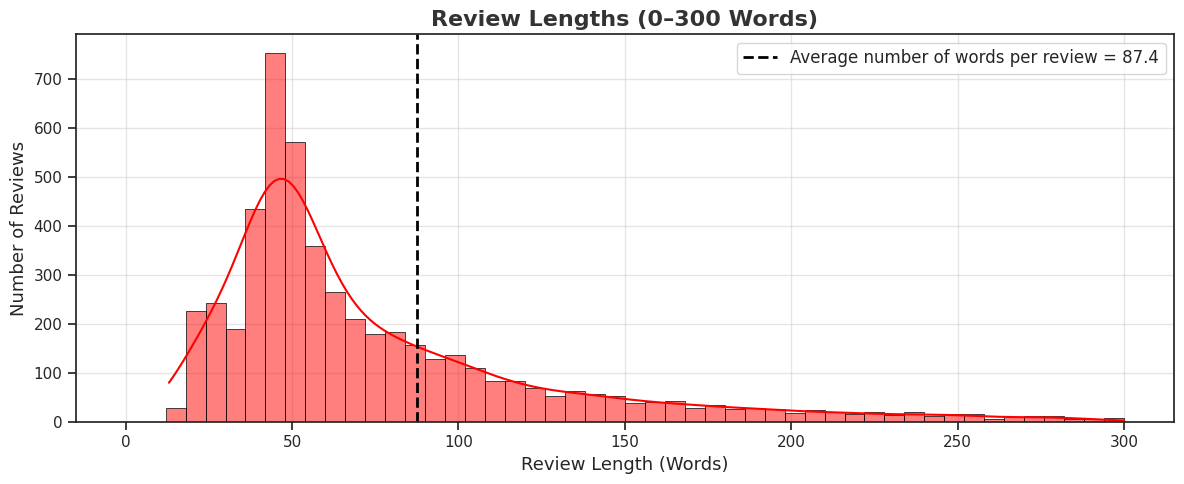

In [11]:
# Calculate review length (in number of words)
data['review_length'] = data['review_text'].fillna('').apply(lambda x: len(x.split()))

# Plot histogram of review lengths
plt.figure(figsize=(12, 5))
sns.histplot(data[data['review_length'] <= 300]['review_length'], bins=50, binrange=[0,300], color='red', kde=True,
             edgecolor='black', linewidth=0.5, stat='count')

plt.title('Review Lengths (0–300 Words)', fontweight="bold", fontsize=16, color='#333333')
plt.xlabel('Review Length (Words)',  fontsize=13, fontweight='medium')
plt.ylabel('Number of Reviews',  fontsize=13, fontweight='medium')
plt.grid(True, alpha=0.5)

# Add average line
avg_length = data['review_length'].mean()
plt.axvline(avg_length, color='black', linestyle='--', linewidth=2, label=f'Average number of words per review = {avg_length:.1f}')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show();

> #### Interpretation:
> **The majority of reviews fall between 0 and 100 words with the average length being 87.4 words, indicating that most users tend to write concise, focused feedback.**

---

#### Chart 2: Distribution of Review Ratings (Log Scale)

The following bar chart displays the number of TripAdvisor reviews across different star ratings (1 to 5). Each bar represents a count of how many times a specific rating was given by reviewers. The y-axis uses a logarithmic scale because the review counts are heavily skewed.

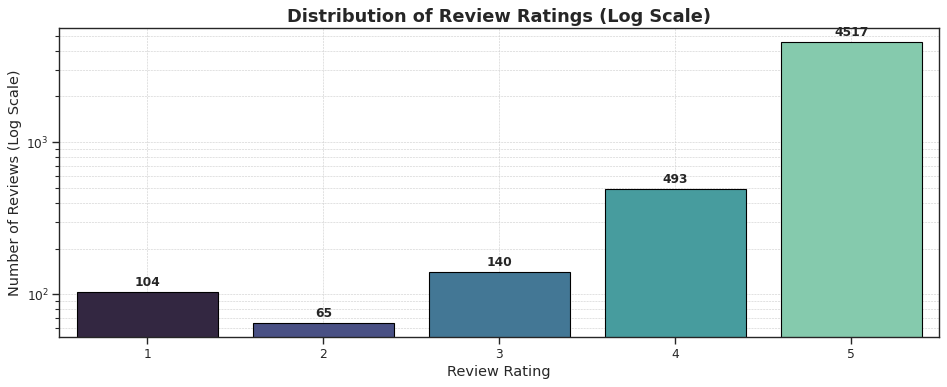

In [12]:
# Count review ratings
rating_counts = data['review_rating'].value_counts().sort_index()

plt.figure(figsize=(12, 5), dpi=80)
ax = sns.countplot(data=data, x='review_rating', palette="mako", edgecolor='black',linewidth=1)
plt.yscale("log") 

# Add text labels above each bar
for bar in ax.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height * 1.05,  f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='semibold'
    )

plt.title('Distribution of Review Ratings (Log Scale)', fontweight="bold", fontsize=16)
plt.xlabel('Review Rating', fontsize=13, fontweight='medium')
plt.ylabel('Number of Reviews (Log Scale)', fontsize=13, fontweight='medium')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show();

> #### Interpretation:
> - **5-star reviews dominate the dataset, indicating a strong positive sentiment among reviewers.**
> - **Lower ratings (1 to 3 stars) are comparatively rare.**
> - **The distribution suggests most hotels have been rated very positively.**

---
#### Chart 3: Distribution of Average number of words in reviews (review length) for each review rating (from 1 to 5 stars).

This bar chart helps us see whether people tend to write longer or shorter reviews based on how satisfied they were.

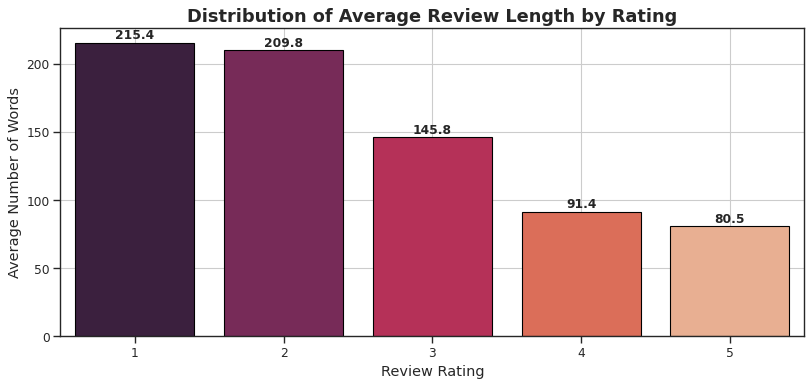

In [13]:
# Plot Average Review Length by Rating
plt.figure(figsize=(12,5), dpi=80)
ax = sns.barplot(data=data, x='review_rating', y='review_length', palette='rocket', ci=None, edgecolor='black', linewidth=1)

plt.title('Distribution of Average Review Length by Rating', fontweight="bold", fontsize=16)
plt.xlabel('Review Rating', fontsize=13, fontweight='medium')
plt.ylabel('Average Number of Words', fontsize=13,fontweight='medium')
plt.grid(True)

# Add text labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2, y=height + 1, s=f'{height:.1f}', ha='center', va='bottom',fontsize=11,fontweight='bold'
    )

plt.show();

> #### Interpretation:
> - **Negative reviews (1–2★) are longer and more detailed, as unhappy guests often vent and describe issues extensively.**
> - **Positive reviews (4–5★) are short and upbeat, with satisfied guests keeping feedback brief and cheerful.**
> - **Neutral reviews (3★) are balanced and reflective, often mentioning both pros and cons with moderate length.**

---

#### Chart 4: Distribution of Top 10 Hotel Locations by Review Count

The following horizontal bar chart shows the top 10 hotel locations in Sri Lanka with the highest number of reviews in the TripAdvisor.

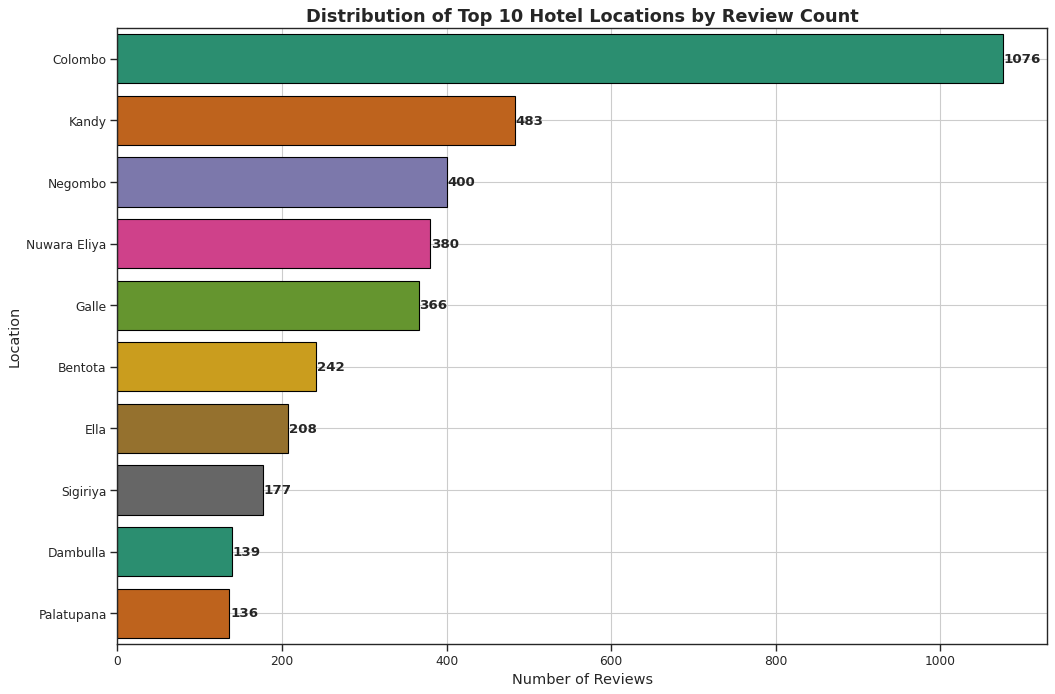

In [14]:
# Calculate top 10 most famous locations based on number of reviews
top_locations = data['hotel_location'].value_counts().head(10)

plt.figure(figsize=(15, 10), dpi=80)
sns.barplot(x=top_locations.values, y=top_locations.index, palette="Dark2", ci=None, edgecolor='black', linewidth=1)

# Adding text labels to the bars
x = top_locations.values
for i, v in enumerate(x):
    plt.text(v + 1, i, str(v), ha='left', va='center', fontsize=12, fontweight="bold")

plt.title('Distribution of Top 10 Hotel Locations by Review Count', fontweight="bold", fontsize=16)
plt.xlabel('Number of Reviews', fontsize=13, fontweight='medium')
plt.ylabel('Location', fontsize=13, fontweight='medium')
plt.grid(True)
plt.show();

> #### Interpretation:
> - **Colombo leads with the highest number of reviews (1,076), reflecting its role as the main tourist and business hub.**
> - **Cultural and scenic spots like Kandy, Nuwara Eliya, and coastal cities (Negombo, Galle) follow with strong engagement.**
> - **Smaller destinations (Ella, Sigiriya, Dambulla, Palatupana) attract fewer reviews but indicate niche interest in nature, heritage, and wildlife tourism.**
---

#### Chart 5: Distribution of Reviews by Trip Types

The following pie chart visualizes the proportion of TripAdvisor hotel reviews grouped by trip type, based on what travelers selected.

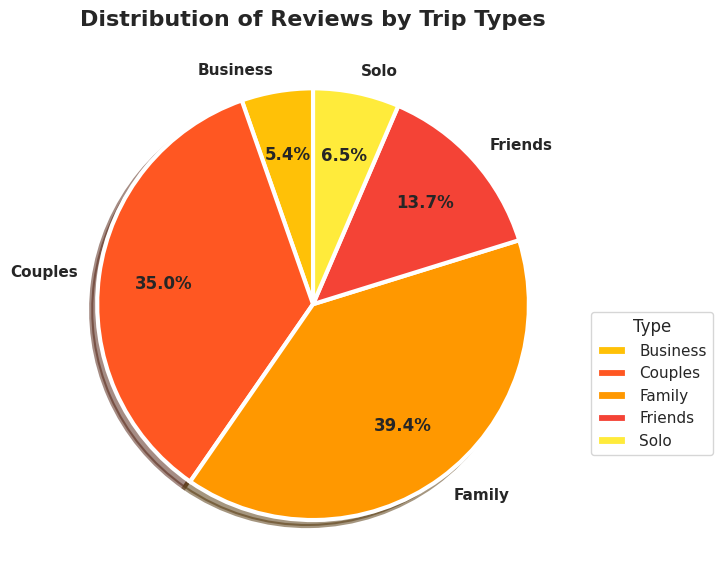

In [15]:
# Count the number of trip types
trip_type_counts = data['trip_type'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.title("Distribution of Reviews by Trip Types", fontweight="bold", fontsize=16)

labels = ['Business', 'Couples', 'Family', 'Friends', 'Solo']
colors = ['#FFC107', '#FF5722', '#FF9800', '#F44336', '#FFEB3B']

# Plotting the pie chart
_, _, autotexts = plt.pie(trip_type_counts , labels=labels, colors=colors,
                              autopct='%1.1f%%', startangle=90,
                              wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                              textprops={'size': 11, 'fontweight': "bold"},
                              pctdistance=0.7, shadow=True)

# Adding a legend
plt.legend(title='Type', loc='best', bbox_to_anchor=(1, 0.5))
plt.ylabel('')

# Customizing the text for percentages
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize('medium')

plt.tight_layout()
plt.show();

> #### Interpretation:
> - **Family trips (2,040 reviews) and Couples trips (1,810 reviews) dominate the dataset, suggesting that most reviewers are traveling for leisure with family or partners.**
> - **Friends trips (711 reviews) form the next largest group, reflecting social group travel.**
> - **Solo travelers (334 reviews) and Business travelers (277 reviews) contribute the smallest shares of reviews.**
---

#### Chart 6: Distribution of Review Length by Trip Type

This following bar chart shows the length of reviews written by travelers for each trip type to understand which types of trips tend to get more detailed feedback.

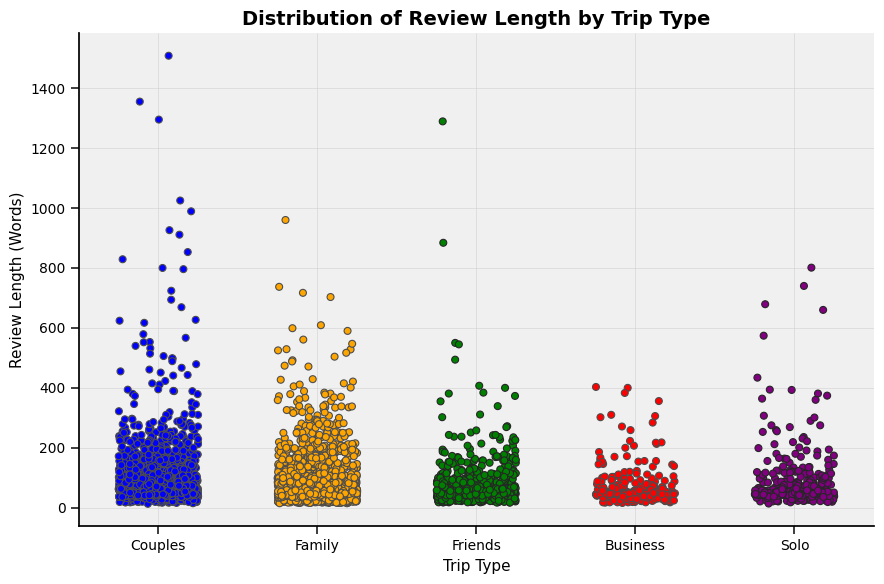

In [16]:
# Define colors for each region
type_colors = {'Family': 'blue', 'Friends': 'orange', 'Business': 'green', 'Couple': 'red', 'Solo': 'purple'}

plot_data = data[data['trip_type'].notna()]
g= sns.catplot(x='trip_type', y='review_length', data=plot_data, kind='strip', jitter=0.25,
                height=6, linewidth=0.8, aspect=1.5, palette=type_colors.values(),legend=False)


# Set labels and title
plt.xlabel('Trip Type', fontsize=11, color='black')
plt.ylabel('Review Length (Words)', fontsize=11, color='black')
plt.title('Distribution of Review Length by Trip Type', fontsize=14, fontweight='bold', color='black')

# Customize tick labels
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

# Customize grid lines
plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)

# Customize background color
plt.gca().set_facecolor('#F0F0F0')

# Customize border color
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()
plt.show();

> #### Interpretation:
> - **Families & Couples often write the longest reviews (200+ words), reflecting detailed experiences with group needs or shared moments.**
> - **Solo & Friends travelers write moderately long reviews—less frequent above 200 words—often more casual or personal.**
> - **Business Travelers write the shortest reviews, rarely exceeding 200 words, focusing only on essentials.**
---

#### Chart 7: Distribution of Most Common Words in Reviews

The following Word Cloud chart visually summarizes the primary words that dominate guest reviews, emphasizing what matters most to your hotel guests after filtering out common generic terms.

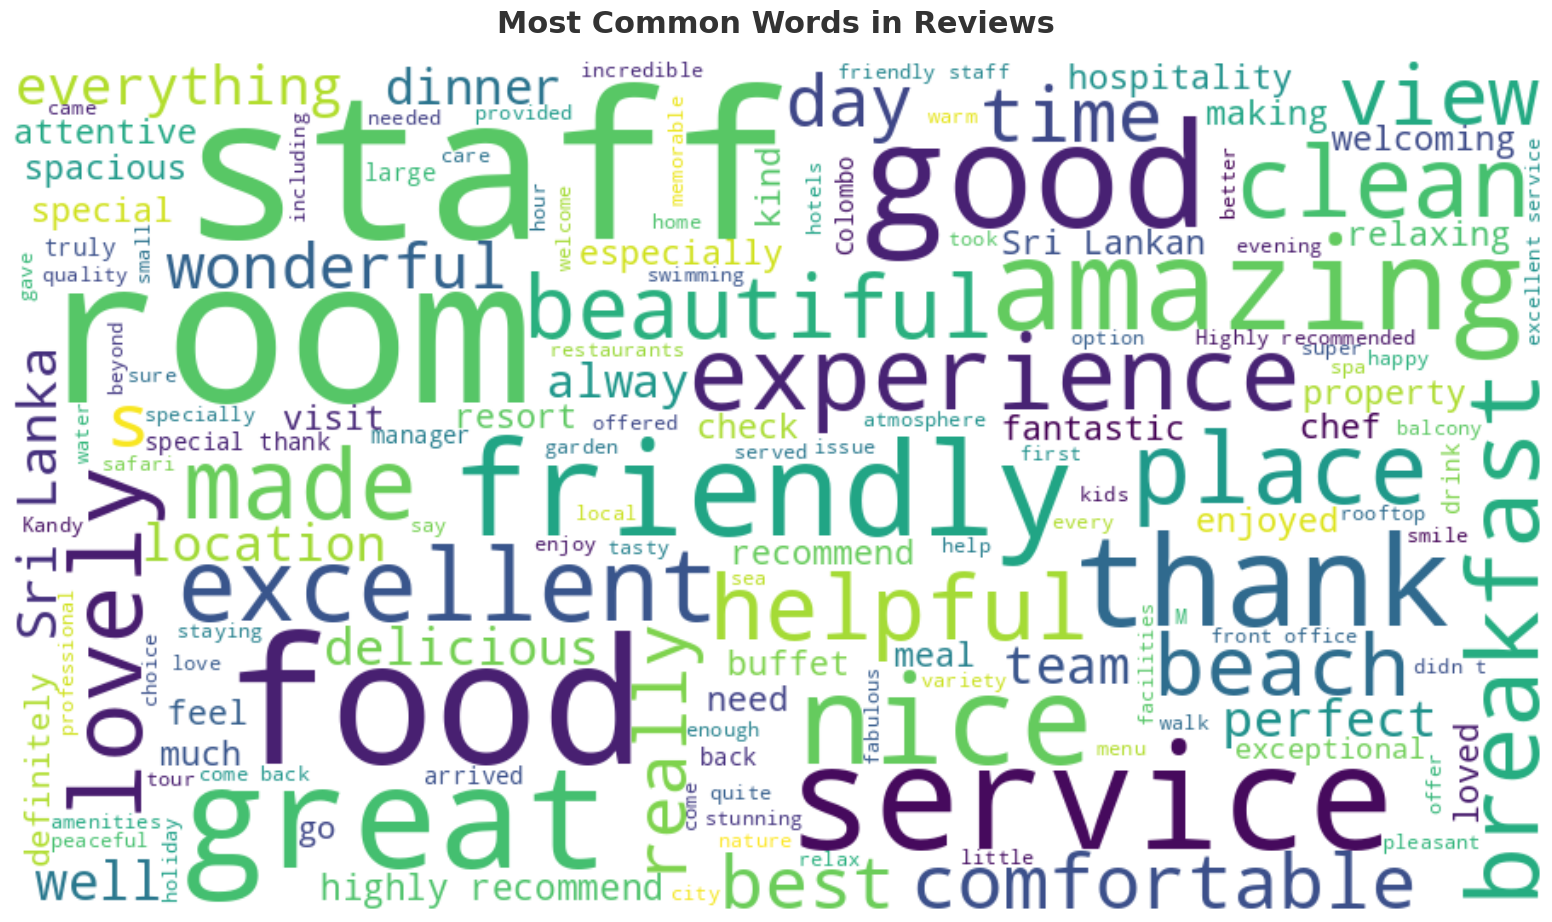

In [17]:
# Add stopwords to remove common filler words
stopwords = set(STOPWORDS)
# Define a custom set of stopwords that are specific to hotel reviews and add them to the stopword list
custom_stopwords = {'hotel', 'stay', 'stayed', 'night', 'nights', 'bed', 'beds', 'price', 'area', 'bathroom', 'wifi','internet', 'reception',
                    'check-in', 'check-out', 'lobby', 'pool',
                    'bar', 'restaurant', 'floor', 'elevator', 'booking', 'reservation', 'trip','travel', 'guest', 'guests', 'will', 'one', 'two',
                    'got', 'did', 'even', 'went', 'make', 'take', 'way', 'want', 'felt', 'bit','everyone', 'people', 'family', 'friend', 
                    'kid', 'us', 'mr', 'mrs', 'thing', 'moment','overall', 'lot', 'many', 'around', 'throughout', 'see', 'right'
                }
stopwords.update(custom_stopwords)

# Drop missing reviews and join them with spaces
text = ' '.join(data['review_text'].dropna())

# Generate a word cloud using the cleaned text
wordcloud = WordCloud(width=900, height=500, background_color='white', stopwords=stopwords, max_words=150, max_font_size=120, random_state=42,
                      colormap='viridis', contour_color='steelblue', contour_width=2
                     ).generate(text)

# Plot the generated word cloud
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews', fontsize=22, fontweight='bold', color='#333333', pad=20)
plt.tight_layout(pad=0)
plt.show();

> #### Interpretation:
> - **Words like _staff_, _friendly_, _helpful_, and _manager_ highlight that attentive, caring service strongly influences guest satisfaction.**
> - **Frequent mentions of _room_, _view_, _spa_, and _pool_ show guests value spacious, comfortable accommodations and relaxing facilities.**
> - **Guests use glowing terms like _amazing_ and _wonderful_, indicating memorable experiences, while mentions of places like Kandy and Colombo reflect interest in location and local culture.**
---

#### Trying out different tokenization schemes.

Tokenizers tested included basic approaches like **Whitespace** and **Regex**, standard NLP tools like **NLTK (Word and Casual tokenizers)**, advanced models like **spaCy**, and subword-level tokenization using **BERT's WordPiece**. 

Each tokenizer was benchmarked on runtime, average token count, and tokenization granularity to understand the trade-offs between speed, accuracy, and suitability for downstream tasks. The goal was to identify the most appropriate tokenizer based on their performance and effectiveness.

In [19]:
# Extract all non-missing review_text entries from the DataFrame, convert them to strings, and put them into a Python list
texts = data['review_text'].dropna().astype(str).tolist()

# Define Tokenizers + Timing

# Whitespace
def tokenize_whitespace(text):
    return text.split()

# Regex
def tokenize_regex(text):
    return re.findall(r"\b\w+\b|[^\w\s]", text)

# NLTK
def tokenize_nltk_word(text):
    return word_tokenize(text)

def tokenize_nltk_casual(text):
    return casual_tokenize(text)

# spaCy
nlp_spacy = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def tokenize_spacy(text):
    return [token.text for token in nlp_spacy(text)]

# Huggingface BERT
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_bert(text):
    return bert_tokenizer.tokenize(text)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
# Measure Time, Token Count and Average Token Count,
def benchmark_tokenizer(name, func, texts):
    start = perf_counter()
    tokens_list = [func(text) for text in texts]
    # Record the end time after tokenization
    end = perf_counter()
    # Calculate the total number of tokens across all texts
    total_tokens = sum(len(tokens) for tokens in tokens_list)
    # Calculate the average number of tokens per text
    avg_tokens = total_tokens / len(texts)
    print(f"{name:<25} | Time: {end - start:.2f}s | Total Tokens: {total_tokens} | Avg Tokens: {avg_tokens:.2f}")
    return {
        'name': name,
        'time': end - start,
        'total_tokens': total_tokens,
        'avg_tokens': avg_tokens
    }

results = []
results.append(benchmark_tokenizer("Whitespace", tokenize_whitespace, texts))
results.append(benchmark_tokenizer("Regex", tokenize_regex, texts))
results.append(benchmark_tokenizer("NLTK Word", tokenize_nltk_word, texts))
results.append(benchmark_tokenizer("NLTK Casual", tokenize_nltk_casual, texts))
results.append(benchmark_tokenizer("spaCy", tokenize_spacy, texts))
results.append(benchmark_tokenizer("BERT (WordPiece)", tokenize_bert, texts))

Whitespace                | Time: 0.05s | Total Tokens: 465001 | Avg Tokens: 87.42
Regex                     | Time: 0.18s | Total Tokens: 539918 | Avg Tokens: 101.51
NLTK Word                 | Time: 3.02s | Total Tokens: 524662 | Avg Tokens: 98.64
NLTK Casual               | Time: 2.15s | Total Tokens: 526451 | Avg Tokens: 98.98
spaCy                     | Time: 35.97s | Total Tokens: 540211 | Avg Tokens: 101.56
BERT (WordPiece)          | Time: 5.81s | Total Tokens: 570562 | Avg Tokens: 107.27


#### Comparison of differnt Tokenizers:

**1- Speed vs Quality:**

**_Whitespace_** and **_Regex_** are fastest but crude, missing punctuation and splitting poorly. **_NLTK_** tokenizers handle punctuation and social text better, with casual tokenizer suited for emojis and slang. **_spaCy_** offers the most accurate linguistic tokenization but is slowest. **_BERT WordPiece_** is slower but essential for Transformer models, breaking words into meaningful subwords.

**2- Token Counts:**

**_Whitespace_** yields the fewest tokens, missing details. **_Regex_**, **_spaCy_**, and **_NLTK_** produce similar, more detailed token counts. **_BERT WordPiece_** produces the most tokens due to subword splitting.

**3- Subword Tokenization Effectiveness:**

**_BERT WordPiece_** excels at handling unseen words and complex morphology, improving downstream model performance, at the cost of more tokens and slower processing.

---

#### Key observations from the EDA:

**Review Length:**
- Most reviews are brief (under 200 words), averaging 87.4 words
- 1-star and 2-star reviews tend to be longer

**Rating Bias:**
- Over 75% of reviews are 4 or 5 stars → heavy positive skew

**Trip Type:**

- Most frequent: Family and Couples
- Least frequent: Business and Solo

**Review Length by Trip Type:**

- Families & Couples write the longest, detailed reviews (200+ words), Solo & Friends write moderately long and personal ones, while Business travelers keep it short and essential.

**Top Reviewed Location:**

- Colombo dominates with 1,076 reviews, reflecting its central role in tourism and business.

---

#### Challenges Encountered:

- The dataset is heavily positively biased, meaning classification models may overpredict positive sentiment unless balanced or weighted.

- BERT tokenizer generated significantly more tokens due to subword splitting, which can increase memory usage and processing time in downstream tasks.

- Emojis, non-English fragments, and reviewer typos challenge lexicon-based tools (like VADER).

---



### 05- Establishing ground truth, using VADER, SentiWordNet, and DistilBERT as sentiment classifiers 

A total of 5320 hotel reviews were processed using three sentiment classifiers. This combination was chosen to leverage the strengths of both lexicon-based and deep learning approaches:
- **VADER**- a rule-based model optimized for social media and informal text, provides quick and interpretable sentiment scoring.
- **SentiWordNet**- a lexicon-based polarity scorer, offers a more linguistically grounded sentiment evaluation using WordNet’s structured lexical database.
- **DistilBERT**- a transformer-based binary sentiment classifierfine-tuned for sentiment analysis, captures nuanced contextual sentiment that lexicon-based models may miss.

By combining these classifiers in a majority voting scheme, can mitigate the individual weaknesses of each and produce a more robust and balanced sentiment label set, serving as a reliable proxy for ground truth in subsequent analysis.

**Label Assignment:**- Each review was passed through all three classifiers. The final sentiment label was assigned using a majority voting scheme.
- If at least two classifiers agreed on a label (Positive or Negative), that label was assigned.
- Reviews with no majority (e.g., all three disagreed or neutral confidence) were labeled as Neutral.

In [21]:
# VADER SentimentIntensityAnalyzer 
vader = SentimentIntensityAnalyzer()

# DistilBERT sentiment analysis pipeline
device = 0 if torch.cuda.is_available() else -1 
hf_sentiment = pipeline(
    "sentiment-analysis",
    model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    revision="714eb0f",
    device=device)

# Convert Penn Treebank POS tags to WordNet POS tags
def penn_to_wn(tag):
    if tag.startswith('N'):
        return wn.NOUN
    if tag.startswith('V'):
        return wn.VERB
    if tag.startswith('J'):
        return wn.ADJ
    if tag.startswith('R'):
        return wn.ADV
    return None

# SentiWordNet Sentiment Scoring function
def sentiwordnet_sentiment(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    sentiment = 0.0
    count = 0
    for word, tag in tagged:
        wn_tag = penn_to_wn(tag)
        if not wn_tag:
            continue
        synsets = list(swn.senti_synsets(word, wn_tag))
        if not synsets:
            continue
        # Take first synset as representative
        synset = synsets[0]
        sentiment += synset.pos_score() - synset.neg_score()
        count += 1
    # If no sentiment words found, return Neutral
    if count == 0:
        return 'Neutral'
    # Average sentiment score across words
    score = sentiment / count
    # Threshold for labeling sentiment
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [22]:
def vader_sentiment(text):
    # Get compound sentiment score using VADER
    score = vader.polarity_scores(text)['compound']

    # Interpret compound score as sentiment label
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

def hf_sentiment_label(text):
    result = hf_sentiment(text[:512])[0]  # truncate long text

    # Convert model label to consistent format
    return 'Positive' if result['label'] == 'POSITIVE' else 'Negative'

In [23]:
def majority_vote(labels):
    # Count how many times each label appears
    count = Counter(labels)
    most_common = count.most_common(1)[0][0]
    return most_common

def assign_sentiment(text):
    # Get sentiment predictions from three different tools
    labels = [
        vader_sentiment(text),
        sentiwordnet_sentiment(text),
        hf_sentiment_label(text)
    ]
    return majority_vote(labels)

# Apply ensemble sentiment function to all reviews
data['ground_truth_sentiment'] = data['review_text'].apply(assign_sentiment)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [24]:
print(data['ground_truth_sentiment'].value_counts())

ground_truth_sentiment
Positive    5172
Negative     138
Neutral        9
Name: count, dtype: int64


Sentiment labels were assigned via majority voting.

In [25]:
data_binary = data[data['ground_truth_sentiment'] != 'Neutral']
data_binary['label'] = data_binary['ground_truth_sentiment'].map({'Positive': 1, 'Negative': 0})

**Due to a negligible number of Neutral reviews (0.17%), the dataset was converted into a binary classification task by removing Neutral samples. Attempts to include it using class weighting or class-balanced loss functions proved ineffective. Models either ignored the Neutral class entirely or misclassified it due to insufficient training samples, leading to unstable performance and degraded metrics across all classes.**

Moreover, Neutral sentiment in user-generated hotel reviews is inherently ambiguous. Many such reviews contain both praise and criticism, making them hard to distinguish cleanly without manual annotation. The ensemble method may have inconsistently labeled borderline cases as Neutral, introducing noise rather than clarity.

In [26]:
print(data_binary['ground_truth_sentiment'].value_counts())

ground_truth_sentiment
Positive    5172
Negative     138
Name: count, dtype: int64


**The final dataset contains 5173 Positive and 138 Negative reviews.**

In [27]:
# Saving the output to a csv
data_binary.to_csv("processed_sentiment_data.csv", index=False)

In [28]:
#Load the processed data
processed_df = pd.read_csv("processed_sentiment_data.csv")

#### Text preprocessing using regular expressions and spaCy's natural language processing pipeline.

**Basic Cleaning using Regex:**

Using simple regex-based cleaning for BERTopic is reasonable because BERTopic’s clustering and topic modeling rely on preserving the general context and vocabulary. Over-cleaning could remove nuances that help differentiate topics, so minimal cleaning helps keep meaningful tokens intact.

- Lowercasing for consistency.
- URL Removal: Deletes any link-like text.
- HTML Removal: Deletes <tags>.
- Symbol Removal: Keeps only alphabets and spaces.

**Tokenization, Lemmatization, Stopword Removal using spaCy processing:**

- nlp(text): spaCy tokenizes and analyzes the text.
- token.lemma_: Reduces words to their root form (e.g., "running" → "run").
- token.is_alpha: Keeps only alphabetical tokens (removes numbers etc.).
- not token.is_stop: Removes stopwords like "the", "and", "is", etc.

 The combined effect of these steps resulted in the _cleaned_review_ column, providing normalized and concise textual data optimized for effective feature extraction and classification model training.

In [29]:
# Basic cleaning using regex
def basic_text_cleaning(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)   # Remove URLs
    text = re.sub(r'<.*?>', '', text)                     # Remove HTML
    text = re.sub(r'[^a-z\s]', '', text)                  # Remove non-alphabetic
    return text

# spaCy processing: lemmatization + stopword removal
def process_with_spacy(text, nlp_model):
    doc = nlp_model(text)
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return ' '.join(tokens)

# Apply the functions
processed_df['basic_text_cleaning'] = processed_df['review_text'].apply(basic_text_cleaning)
processed_df['cleaned_review'] = processed_df['basic_text_cleaning'].apply(lambda x: process_with_spacy(x, nlp))
processed_df.head(5)

,hotel_location,hotel_name,review_rating,review_title,review_text,trip_type,review_length,ground_truth_sentiment,label,basic_text_cleaning,cleaned_review
0,Sigiriya,Sigiriya Village Hotel,5,Hotels,Friendly staff. Nature resort. Sigiriya rock v...,Couples,18,Positive,1,friendly staff nature resort sigiriya rock vie...,friendly staff nature resort sigiriya rock vie...
1,Sigiriya,Sigiriya Village Hotel,5,Excellent hotel,Fantastic staff so helpful beautiful peaceful...,Family,18,Positive,1,fantastic staff so helpful beautiful peaceful...,fantastic staff helpful beautiful peaceful loc...
2,Sigiriya,Sigiriya Village Hotel,5,The pool area and the welcome drink was really...,Really had a great time with my family really ...,Family,24,Positive,1,really had a great time with my family really ...,great time family helpful staff location waa c...
3,Sigiriya,Sigiriya Village Hotel,5,Pool area neat,"All good reception sadurshan,nadeesha,geethika...",Friends,43,Positive,1,all good reception sadurshannadeeshageethika m...,good reception sadurshannadeeshageethika mr sa...
4,Sigiriya,Sigiriya Village Hotel,5,Beautiful authentic resort,Beautiful resort with lovely garden and pool. ...,Couples,33,Positive,1,beautiful resort with lovely garden and pool v...,beautiful resort lovely garden pool clean amen...


#### Key observations from establishing ground truth

**1- Classification Dataset Overview**
- Source: User reviews scraped from 116 Sri Lankan hotels on TripAdvisor
- Total Reviews Collected: 5,32
- Raw Columns: hotel_location, hotel_name, review_rating, review_title, review_text, trip_type
- Target Field for Classification: - review_text (used for sentiment analysis)

**2- Label Generation (Ground Truth)**

Tools Used:
- VADER: Rule-based sentiment analyzer
- SentiWordNet: Lexicon-based polarity scorer
- DistilBERT (HuggingFace): Transformer-based binary sentiment classifier

**Initial classification: 3 classes → Positive, Negative, Neutral**

After processing, reviews labeled as Neutral accounted for less than 0.2% of the dataset and were removed to convert the task into a binary classification problem.

Dataset Shape:
- Positive: 5,173 reviews
- Negative: 138 reviews

**This process resulted in a binary-labeled dataset with 5,311 reviews, forming the ground truth for training and evaluation in subsequent tasks.**

**3- Text Preprocessing Steps Applied**

- Lowercasing: Converted all text to lowercase to ensure consistency.
- Noise Removal: Used regular expressions to remove URLs, HTML tags, and non-alphabetic characters.
- Tokenization: Applied spaCy's tokenizer to segment text into meaningful tokens.
- Stopword Removal: Discarded common English stopwords to reduce noise.
- Lemmatization: Reduced words to their base forms for better generalization.

### 06- Feature Extraction 

To ensure a comprehensive evaluation of textual features for sentiment classification, two sparse and two dense vectorization methods were selected based on their distinct representational strengths. 

**CountVectorizer (BoW) and TF-IDF were chosen as sparse techniques.**

- CountVectorizer is a simple yet effective baseline that encodes term frequencies without considering context, offering transparency and interpretability. TF-IDF builds on this by reducing the influence of high-frequency, low-information words, allowing the model to focus on more discriminative terms this often improves classification performance in real-world reviews. 

**For dense vectorization, Word2Vec and GloVe were selected.** 

- Word2Vec captures local semantic relationships through contextual prediction, enabling better generalization on unseen text. GloVe complements this by incorporating global co-occurrence statistics, making it more robust for longer-range dependencies in text.

**Combining both these types can cover both syntactic frequency patterns (sparse) and semantic meaning (dense). It enables comparison between classic bag-of-words approaches and modern embedding techniques.**

The top 10,000 features were selected for the sparse methods to balance computational efficiency with sufficient vocabulary coverage, ensuring that the most informative unigrams and bigrams are retained while avoiding excessive sparsity.

---

#### 1. Sparse Vectorizer: CountVectorizer

In [30]:
# Initialize
count_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)

# Fit and transform
X_count = count_vectorizer.fit_transform(processed_df['cleaned_review'])

# Check shape
print("CountVectorizer shape:", X_count.shape)

CountVectorizer shape: (5310, 10000)


#### 2. Sparse Vectorizer: TF-IDF Vectorizer

In [31]:
# Initialize
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)

# Fit and transform
X_tfidf = tfidf_vectorizer.fit_transform(processed_df['cleaned_review'])

# Check shape
print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (5310, 10000)


#### 3. Dense Vectorizer: Word2Vec Average Embeddings

In [32]:
model_path = '/kaggle/input/word2vec/word2vec_google_news_300.model'

# Downloaded pretrained Word2Vec
w2v = KeyedVectors.load(model_path)

def get_avg_w2v(tokens):
    vectors = [w2v[word] for word in tokens if word in w2v]
    return mean(vectors, axis=0) if vectors else zeros(300)

# Tokenize text
processed_df['tokens'] = processed_df['cleaned_review'].apply(str.split)

# Apply
X_w2v = np.vstack(processed_df['tokens'].apply(get_avg_w2v))
print("Word2Vec shape:", X_w2v.shape)

Word2Vec shape: (5310, 300)


#### 4. Dense Vectorizer: GloVe Average Embeddings

In [33]:
# Downloaded pretrained Glove_Avg
glove_path = '/kaggle/input/glove-300/glove.6B.300d.txt'

# Load GloVe vectors
def load_glove(path):
    glove = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vec = np.array(parts[1:], dtype='float32')
            glove[word] = vec
    return glove

glove = load_glove(glove_path)

def get_avg_glove(tokens):
    vectors = [glove[word] for word in tokens if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

# Apply
X_glove = np.vstack(processed_df['tokens'].apply(get_avg_glove))
print("GloVe shape:", X_glove.shape)

GloVe shape: (5310, 300)


#### Feature Extraction and Resulting Data Shapes

After text preprocessing, four feature extraction methods were applied to convert 5,310 hotel reviews into machine-readable vectors suitable for classification. This includes two sparse vector methods and two dense vector methods, ensuring a diverse representation of textual data.

**Sparse Feature Sets:**
| Method            | Shape           | Justification                                                                                                                                                                            |
| ----------------- | --------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| CountVectorizer   | (5,310, 10,000) | Captures raw frequency counts of unigrams and bigrams across the corpus. Suitable for models that benefit from explicit token presence but results in high-dimensional, sparse matrices. |
| TF-IDF Vectorizer | (5,310, 10,000) | Similar to CountVectorizer but applies inverse document frequency weighting, reducing the impact of commonly occurring words. Effective for highlighting unique tokens within reviews.   |

Both sparse methods produce a 5,310 × 10,000 matrix: 

- **Rows (5,310)**
- **Columns (10,000)**: Top 10,000 tokens (unigrams and bigrams), representing the feature space.

**Dense Feature Sets:**
| Method              | Shape        | Justification                                                                                                                                                               |
| ------------------- | ------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Word2Vec (Averaged) | (5,310, 300) | Represents each review as the average of 300-dimensional pre-trained word vectors (Google News embeddings). Captures semantic similarity between words efficiently.         |
| GloVe (Averaged)    | (5,310, 300) | Similar to Word2Vec but trained on global co-occurrence statistics from Wikipedia and Gigaword. Provides alternative semantic capture, useful for comparison with Word2Vec. |

Both dense methods produce a 5,310 × 300 matrix:

- **Rows (5,310)**
- **Columns (300)**: Continuous embedding dimensions representing semantic meaning.

### 07- Non-deep Learning Algorithms for Classification

| Model                   | Why It Was Chosen                                                     |
| ----------------------- | --------------------------------------------------------------------- |
| **Logistic Regression** | Strong, fast baseline, interpretable, good with sparse features       |
| **SVM (Linear Kernel)** | Excellent for text, handles class imbalance, strong decision boundary |
| **XGBoost**             | Powerful ensemble method, handles non-linearity and class imbalance   |


**1. Logistic Regression**- A strong, interpretable baseline for binary classification tasks with text data.
- Works well with high-dimensional sparse data (e.g., TF-IDF, BoW).
- Outputs calibrated probabilities → useful for interpretation and threshold tuning.
- Frequently used in sentiment analysis literature as a reliable baseline.

**Justification:**
Logistic Regression is chosen for its simplicity, speed, and strong performance on linearly separable text data when used with TF-IDF or count vectors. It provides a solid baseline for sentiment prediction.

**2. Support Vector Machine (SVM) with Linear Kernel**- Known for superior performance in text classification tasks.
- Handles high-dimensional, sparse feature vectors very well.
- Works great when there’s a clear decision boundary (e.g., sentiment polarity).
- Often outperforms logistic regression when classes are imbalanced (with tuning).

**Justification:**
SVM is selected due to its robustness in handling sparse vectorized text and its proven effectiveness in sentiment classification, particularly under class imbalance when using class weighting.

**3. XGBoost**- A powerful gradient boosting algorithm, widely used in machine learning competitions and practical applications.

- Handles both sparse and dense feature representations effectively.
- Captures complex non-linear relationships in the data.
- Has built-in mechanisms for handling class imbalance.
- Regularization reduces overfitting compared to other boosting models.

**Justification:**
XGBoost is chosen for its ability to model non-linear feature interactions in text classification tasks. When TF-IDF or BoW features are used, XGBoost can outperform linear models by leveraging gradient boosting with regularization and tree-based splits. It is especially beneficial when linear decision boundaries aren’t sufficient.


#### Part A: Handling Class Imbalance

This sentiment classification task suffers from skewed class distributions, particularly with fewer negative reviews compared to positive ones. Additionally, overfitting poses a significant risk when training models on high-dimensional text data. To address both concerns, a combination of data-level and model-level strategies was applied.

#### Strategy 1: Class Weight Adjustment

The first approach maintained the original data distribution and instead adjusted how models penalized classification errors:
- Logistic Regression and SVM used **class_weight='balanced'**.
- XGBoost used **scale_pos_weight** to give more weight to the minority class.

This approach increases the loss penalty for misclassifying negative reviews, allowing models to better learn from underrepresented classes without duplicating data. It preserves the real-world class proportions, avoids artificial inflation of data, and is computationally efficient.

**Some imbalance is intrinsic, especially in review datasets where positive sentiment dominates. Instead of forcing a balanced distribution, this method respects the natural occurrence of classes while still addressing bias during training.**

#### Strategy 2: Oversampling with SMOTE (Synthetic Minority Over-sampling Technique)

The second approach addresses class imbalance issues by generating synthetic samples for the minority class through interpolation between existing minority instances and their nearest neighbors, rather than simply duplicating them.

It enhances the model's ability to generalize on underrepresented classes, making it a valuable technique in aspect-based sentiment classification when class imbalance is present.


#### Part B: Mitigating Overfitting

To ensure robust and generalizable models, a range of anti-overfitting techniques was implemented across all classifiers:

**1- Regularization (Logistic Regression & SVM)**- Penalizes overly complex models to reduce the risk of learning noise.
- The regularization parameter was set to **C = 0.1**, increasing the penalty on large coefficients.
- Helps the model focus on the most important features and avoid overfitting to idiosyncratic patterns in the training set.

**2- Class Weighting (All Classifiers)**: Prevents the models from becoming biased toward the majority class by penalizing misclassification of minority class reviews more heavily.

Handled class imbalance using:

- **class_weight='balanced'(Logistic Regression, SVM)**
- **scale_pos_weight (XGBoost)**

**3- Tree Complexity Control (XGBoost)**- These hyperparameters prevent overly deep or overly granular trees, reducing variance and improving generalization.

- **max_depth=4**: Limits tree depth to avoid over-specific splits.
- **min_child_weight=5**: Ensures leaves have a sufficient number of samples.

**4-Subsampling (XGBoost)**- Introduces randomness, which lowers tree correlation and reduces overfitting.

- **subsample=0.8**: Only 80% of data used per tree.
- **colsample_bytree=0.8**: Only 80% of features used per tree.

**5- Learning Rate Reduction (XGBoost)**- Enables gradual convergence, ensuring the model doesn't overfit early on by making large weight updates.

- **learning_rate=0.1**: Slows down updates.

**Model Evaluation**: Cross-validation was used during model evaluation, but emphasis was placed on average scores across folds to maintain clarity. Detailed per-fold outputs were omitted to avoid noise and maintain focus on aggregate performance metrics.

#### Strategy 1: Class Weight Adjustment

In [34]:
# Select the cleaned review text
model_data = processed_df[['cleaned_review', 'label']]

def train_and_evaluate(X, y, classifier_name, feature_set_name, strategy='balanced', test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    print(f"\n--- {feature_set_name} | {classifier_name.upper()} ---")

    # Apply SMOTE oversampling only on training data if specified
    if strategy == 'oversample':
        smote = SMOTE(sampling_strategy=0.75, k_neighbors=5, random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    # Set up model based on classifier name
    if classifier_name == 'logreg':
        model = LogisticRegression(
            max_iter=1000,
            class_weight='balanced' if strategy == 'balanced' else None,  # Handle imbalance
            C=0.1  
        )

    elif classifier_name == 'svm':
        model = LinearSVC(
            class_weight='balanced' if strategy == 'balanced' else None,
            C=0.1  
        )

    elif classifier_name == 'xgb':
        # Adjust scale_pos_weight for imbalanced data if using 'balanced' strategy
        scale_pos_weight = (sum(y_train == 0) / sum(y_train == 1)) if strategy == 'balanced' else 1
        model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            scale_pos_weight=scale_pos_weight,
            max_depth=4,
            min_child_weight=5,
            subsample=0.8,
            colsample_bytree=0.8,
            learning_rate=0.1
        )

    else:
        raise ValueError("Invalid classifier name.")

    # Train the model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Evaluate performance on label=1 (majority class)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    # Print results
    print(f"\nAccuracy: {acc * 100:.2f}% | F1-Score: {f1 * 100:.2f}%")
    print(classification_report(y_test, y_pred))

    return acc, f1

# Evaluate multiple feature sets with multiple classifiers
def evaluate_all_feature_sets(X_sets, y, strategy='balanced', test_size=0.2):

    # Store results for all combinations
    results = []

    # Loop through each feature representation
    for feature_name, X in X_sets.items():
        for clf_name in ['logreg', 'svm', 'xgb']:
            # Train and evaluate model
            acc, f1 = train_and_evaluate(X, y, clf_name, feature_name, strategy=strategy, test_size=test_size)
            results.append({
                'Feature_Set': feature_name,
                'Classifier': clf_name.upper(),
                'Accuracy': round(acc * 100, 2),
                'F1_Score': round(f1 * 100, 2)
            })
    return results

In [35]:
# Usage:
X_sets = {
    'CountVectorizer': X_count,
    'TF-IDF': X_tfidf,
    'Word2Vec_Avg': X_w2v,
    'GloVe_Avg': X_glove
}

results_balanced = evaluate_all_feature_sets(X_sets,  y=model_data['label'], strategy='balanced')


--- CountVectorizer | LOGREG ---

Accuracy: 98.21% | F1-Score: 99.08%
              precision    recall  f1-score   support

           0       0.70      0.57      0.63        28
           1       0.99      0.99      0.99      1034

    accuracy                           0.98      1062
   macro avg       0.84      0.78      0.81      1062
weighted avg       0.98      0.98      0.98      1062


--- CountVectorizer | SVM ---

Accuracy: 98.02% | F1-Score: 98.99%
              precision    recall  f1-score   support

           0       0.73      0.39      0.51        28
           1       0.98      1.00      0.99      1034

    accuracy                           0.98      1062
   macro avg       0.86      0.69      0.75      1062
weighted avg       0.98      0.98      0.98      1062


--- CountVectorizer | XGB ---

Accuracy: 86.82% | F1-Score: 92.78%
              precision    recall  f1-score   support

           0       0.14      0.79      0.24        28
           1       0.99      0

#### Evaluation and Interpretation of Classifier Performance (Strategy 1: Class Weights)

| Vectorizer     | Model           | Accuracy (%) | Metric    | Class | Precision | Recall | F1-Score | Support |
|----------------|-----------------|--------------|-----------|-------|-----------|--------|----------|---------|
| **CountVectorizer** | **Logistic Reg.**   | 98.21        | 0.70      | 0     | 0.70      | 0.57   | **0.63**     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.99   | 0.99     | 1034    |
|                |                 |              | Macro Avg | -     | 0.84      | 0.78   | 0.81     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.98   | 0.98     | 1062    |
| CountVectorizer | SVM             | 98.02        | 0.73      | 0     | 0.73      | 0.39   | 0.51     | 28      |
|                |                 |              |           | 1     | 0.98      | 1.00   | 0.99     | 1034    |
|                |                 |              | Macro Avg | -     | 0.86      | 0.69   | 0.75     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.98   | 0.98     | 1062    |
| CountVectorizer | XGBoost         | 86.82        | 0.14      | 0     | 0.14      | 0.79   | 0.24     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.87   | 0.93     | 1034    |
|                |                 |              | Macro Avg | -     | 0.57      | 0.83   | 0.58     | 1062    |
|                |                 |              | Weighted  | -     | 0.97      | 0.87   | 0.91     | 1062    |
| TF-IDF         | Logistic Reg.   | 96.52        | 0.42      | 0     | 0.42      | 0.79   | 0.54     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.97   | 0.98     | 1034    |
|                |                 |              | Macro Avg | -     | 0.70      | 0.88   | 0.76     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.97   | 0.97     | 1062    |
| TF-IDF         | SVM             | 97.55        | 0.53      | 0     | 0.53      | 0.61   | 0.57     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.99   | 0.99     | 1034    |
|                |                 |              | Macro Avg | -     | 0.76      | 0.80   | 0.78     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.98   | 0.98     | 1062    |
| TF-IDF         | XGBoost         | 88.79        | 0.16      | 0     | 0.16      | 0.79   | 0.27     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.89   | 0.94     | 1034    |
|                |                 |              | Macro Avg | -     | 0.58      | 0.84   | 0.60     | 1062    |
|                |                 |              | Weighted  | -     | 0.97      | 0.89   | 0.92     | 1062    |
| Word2Vec_Avg   | Logistic Reg.   | 92.00        | 0.23      | 0     | 0.23      | 0.89   | 0.37     | 28      |
|                |                 |              |           | 1     | 1.00      | 0.92   | 0.96     | 1034    |
|                |                 |              | Macro Avg | -     | 0.62      | 0.91   | 0.66     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.92   | 0.94     | 1062    |
| Word2Vec_Avg   | SVM             | 93.97        | 0.29      | 0     | 0.29      | 0.89   | 0.44     | 28      |
|                |                 |              |           | 1     | 1.00      | 0.94   | 0.97     | 1034    |
|                |                 |              | Macro Avg | -     | 0.64      | 0.92   | 0.70     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.94   | 0.95     | 1062    |
| Word2Vec_Avg   | XGBoost         | 95.01        | 0.31      | 0     | 0.31      | 0.75   | 0.44     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.96   | 0.97     | 1034    |
|                |                 |              | Macro Avg | -     | 0.65      | 0.85   | 0.71     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.95   | 0.96     | 1062    |
| GloVe_Avg      | Logistic Reg.   | 92.84        | 0.25      | 0     | 0.25      | 0.86   | 0.39     | 28      |
|                |                 |              |           | 1     | 1.00      | 0.93   | 0.96     | 1034    |
|                |                 |              | Macro Avg | -     | 0.62      | 0.89   | 0.67     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.93   | 0.95     | 1062    |
| **GloVe_Avg**      | **SVM**             | 95.48        | 0.35      | 0     | 0.35      | 0.86   | **0.50**     | 28      |
|                |                 |              |           | 1     | 1.00      | 0.96   | 0.98     | 1034    |
|                |                 |              | Macro Avg | -     | 0.67      | 0.91   | 0.74     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.95   | 0.96     | 1062    |
| GloVe_Avg      | XGBoost         | 93.79        | 0.26      | 0     | 0.26      | 0.75   | 0.39     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.94   | 0.97     | 1034    |
|                |                 |              | Macro Avg | -     | 0.63      | 0.85   | 0.68     | 1062    |
|                |                 |              | Weighted  | -     | 0.97      | 0.94   | 0.95     | 1062    |


##### General Overview

- High overall accuracy (mostly above 90%) and weighted F1-scores (~0.94-0.98) indicate the models perform well on the dominant positive class (label 1).
- However, the minority negative class (label 0) consistently shows much lower precision, recall, and F1-scores due to severe class imbalance (28 negative vs. 1034 positive samples).

##### Detailed Interpretation by Vectorizer and Model

1- CountVectorizer

- Logistic Regression: Balanced performance on negative class (F1 = 0.63), with decent precision (0.70) and recall (0.57). Macro F1 of 0.81 suggests relatively fair performance across classes.
- SVM: Higher precision (0.73) but notably lower recall (0.39) on the negative class, indicating it’s more conservative in predicting negatives and misses many actual negatives.
- XGBoost: Very low precision (0.14) but high recall (0.79) on negatives, meaning it flags many false positives despite catching most negatives. Accuracy is also lower (86.82%), likely dragged down by false positives.

2- TF-IDF

- Logistic Regression: Moderate negative class F1 (0.54) with better recall (0.79) than precision (0.42). This model is more sensitive but less precise on negatives.
- SVM: Balanced precision (0.53) and recall (0.61) for negatives with an F1 of 0.57. Macro F1 of 0.78 suggests reasonable class balance.
- XGBoost: Similar to CountVectorizer, low precision (0.16) but higher recall (0.79) on negatives; overall performance suffers compared to others.

3- Word2Vec (Averaged Embeddings)

- Logistic Regression: Good recall (0.89) but very low precision (0.23) on negatives, yielding low F1 (0.37). The model catches most negatives but misclassifies many positives as negatives.
- SVM: Slight improvement in precision (0.29) and F1 (0.44), recall steady at 0.89.
- XGBoost: Highest F1 on negatives (0.44) among Word2Vec variants, with moderate precision (0.31) and recall (0.75).

4- GloVe (Averaged Embeddings)

- Logistic Regression: Similar pattern to Word2Vec with low precision (0.25) but high recall (0.86), resulting in modest F1 (0.39).
- SVM: Improves precision (0.35) and F1 (0.50) for negatives; macro F1 of 0.74 is the highest among all models, indicating the best balance between classes.
- XGBoost: Low precision (0.26) and moderate recall (0.75) on negatives, with F1 of 0.39; similar to Logistic Regression on GloVe.

##### Key Insights

- **All models perform exceptionally well on the majority positive class, with precision, recall, and F1 all close to or above 0.90.**
- Negative class prediction remains challenging due to the imbalance:
    - Models with higher recall but low precision (e.g., XGBoost) tend to flag many false positives.
    - Models with higher precision but low recall (e.g., SVM with CountVectorizer) miss many negative instances.

- **The best trade-off for negative class detection seems to be with SVM + GloVe embeddings (F1=0.50) and Logistic Regression + CountVectorizer (F1=0.63).**

**Weighted averages and accuracy are inflated by the dominant class; hence, macro averages and negative class metrics provide more meaningful insight into minority class performance.**

#### Strategy 2: Oversampling with SMOTE

In [36]:
# Usage:
X_sets = {
    'CountVectorizer': X_count,
    'TF-IDF': X_tfidf,
    'Word2Vec_Avg': X_w2v,
    'GloVe_Avg': X_glove
}
results_smote = evaluate_all_feature_sets(X_sets, y=model_data['label'], strategy='oversample')


--- CountVectorizer | LOGREG ---

Accuracy: 96.33% | F1-Score: 98.10%
              precision    recall  f1-score   support

           0       0.37      0.57      0.45        28
           1       0.99      0.97      0.98      1034

    accuracy                           0.96      1062
   macro avg       0.68      0.77      0.72      1062
weighted avg       0.97      0.96      0.97      1062


--- CountVectorizer | SVM ---

Accuracy: 96.89% | F1-Score: 98.40%
              precision    recall  f1-score   support

           0       0.42      0.50      0.46        28
           1       0.99      0.98      0.98      1034

    accuracy                           0.97      1062
   macro avg       0.71      0.74      0.72      1062
weighted avg       0.97      0.97      0.97      1062


--- CountVectorizer | XGB ---

Accuracy: 98.31% | F1-Score: 99.14%
              precision    recall  f1-score   support

           0       0.86      0.43      0.57        28
           1       0.98      1

#### Evaluation and Interpretation of Classifier Performance (Strategy 2: Oversampling with SMOTE)

| Vectorizer     | Model           | Accuracy (%) | Metric    | Class | Precision | Recall | F1-Score | Support |
|----------------|-----------------|--------------|-----------|-------|-----------|--------|----------|---------|
| CountVectorizer | Logistic Reg.   | 96.33        |           | 0     | 0.37      | 0.57   | 0.45     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.97   | 0.98     | 1034    |
|                |                 |              | Macro Avg | -     | 0.68      | 0.77   | 0.72     | 1062    |
|                |                 |              | Weighted  | -     | 0.97      | 0.96   | 0.97     | 1062    |
| CountVectorizer | SVM             | 96.89        |           | 0     | 0.42      | 0.50   | 0.46     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.98   | 0.98     | 1034    |
|                |                 |              | Macro Avg | -     | 0.71      | 0.74   | 0.72     | 1062    |
|                |                 |              | Weighted  | -     | 0.97      | 0.97   | 0.97     | 1062    |
| CountVectorizer | XGBoost         | 98.31        |           | 0     | 0.86      | 0.43   | 0.57     | 28      |
|                |                 |              |           | 1     | 0.98      | 1.00   | 0.99     | 1034    |
|                |                 |              | Macro Avg | -     | 0.92      | 0.71   | 0.78     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.98   | 0.98     | 1062    |
| TF-IDF         | Logistic Reg.   | 97.83        |           | 0     | 0.59      | 0.57   | 0.58     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.99   | 0.99     | 1034    |
|                |                 |              | Macro Avg | -     | 0.79      | 0.78   | 0.79     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.98   | 0.98     | 1062    |
| TF-IDF         | SVM             | 97.93        |           | 0     | 0.62      | 0.57   | 0.59     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.99   | 0.99     | 1034    |
|                |                 |              | Macro Avg | -     | 0.80      | 0.78   | 0.79     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.98   | 0.98     | 1062    |
| TF-IDF         | XGBoost         | 97.93        |           | 0     | 0.67      | 0.43   | 0.52     | 28      |
|                |                 |              |           | 1     | 0.98      | 0.99   | 0.99     | 1034    |
|                |                 |              | Macro Avg | -     | 0.83      | 0.71   | 0.76     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.98   | 0.98     | 1062    |
| Word2Vec_Avg   | Logistic Reg.   | 94.35        |           | 0     | 0.30      | 0.86   | 0.44     | 28      |
|                |                 |              |           | 1     | 1.00      | 0.95   | 0.97     | 1034    |
|                |                 |              | Macro Avg | -     | 0.65      | 0.90   | 0.71     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.94   | 0.96     | 1062    |
| Word2Vec_Avg   | SVM             | 95.76        |           | 0     | 0.37      | 0.86   | 0.52     | 28      |
|                |                 |              |           | 1     | 1.00      | 0.96   | 0.98     | 1034    |
|                |                 |              | Macro Avg | -     | 0.68      | 0.91   | 0.75     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.96   | 0.97     | 1062    |
| Word2Vec_Avg   | XGBoost         | 97.65        |           | 0     | 0.55      | 0.61   | 0.58     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.99   | 0.99     | 1034    |
|                |                 |              | Macro Avg | -     | 0.77      | 0.80   | 0.78     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.98   | 0.98     | 1062    |
| GloVe_Avg      | Logistic Reg.   | 94.54        |           | 0     | 0.30      | 0.82   | 0.44     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.95   | 0.97     | 1034    |
|                |                 |              | Macro Avg | -     | 0.65      | 0.89   | 0.71     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.95   | 0.96     | 1062    |
| **GloVe_Avg**      | **SVM**             | 96.99        |           | 0     | 0.46      | 0.86   | **0.60**     | 28      |
|                |                 |              |           | 1     | 1.00      | 0.97   | 0.98     | 1034    |
|                |                 |              | Macro Avg | -     | 0.73      | 0.92   | 0.79     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.97   | 0.97     | 1062    |
| GloVe_Avg      | XGBoost         | 97.46        |           | 0     | 0.52      | 0.57   | 0.54     | 28      |
|                |                 |              |           | 1     | 0.99      | 0.99   | 0.99     | 1034    |
|                |                 |              | Macro Avg | -     | 0.75      | 0.78   | 0.76     | 1062    |
|                |                 |              | Weighted  | -     | 0.98      | 0.97   | 0.98     | 1062    |

##### General Overview

- Overall accuracy remains high (mostly 94% to 98%) due to dominance of positive class.
- SMOTE oversampling improves recall for the minority class (negative = 0) across almost all models, meaning more negative reviews are correctly identified.
- However, precision on the negative class generally remains low to moderate, reflecting some false positives introduced by oversampling.
- Macro averages (precision, recall, F1) are useful here to gauge balanced performance on both classes.

##### Detailed Interpretation by Vectorizer and Model

1- CountVectorizer

- Logistic Regression: Precision (0.37) and recall (0.57) for negative class remain moderate, with F1 = 0.45. Macro F1 = 0.72 indicates moderate class balance.
- SVM: Slightly better precision (0.42) but lower recall (0.50) on negatives, resulting in F1 = 0.46. Overall balanced macro F1 = 0.72.
- XGBoost: Very high precision (0.86) but lower recall (0.43) for negatives; F1 = 0.57. This means fewer false positives but more false negatives. Macro F1 = 0.78 suggests better class balance but at the cost of missing negatives.

2- TF-IDF
Logistic Regression: Balanced precision (0.59) and recall (0.57) on negative class with F1 = 0.58. Macro F1 = 0.79 indicates relatively strong minority class performance.
SVM: Precision 0.62, recall 0.57 for negatives, F1 = 0.59. Macro F1 also 0.79 — similar to Logistic Regression, showing consistent performance.
XGBoost: Moderate precision (0.67) but lower recall (0.43) for negatives, F1 = 0.52. Macro F1 at 0.76 shows a reasonable trade-off.

3- Word2Vec (Averaged Embeddings)

- Logistic Regression: Low precision (0.30) but high recall (0.86) on negatives, resulting in F1 = 0.44. Macro F1 = 0.71 indicates good recall dominance but poor precision.
- SVM: Improved precision (0.37) and high recall (0.86), F1 = 0.52. Macro F1 = 0.75 reflects better balance than Logistic Regression.
- XGBoost: Higher precision (0.55) and recall (0.61), F1 = 0.58. Macro F1 = 0.78 — the best among Word2Vec models here.

4- GloVe (Averaged Embeddings)

- Logistic Regression: Low precision (0.30), high recall (0.82), F1 = 0.44. Macro F1 = 0.71, indicating recall-driven performance.
- SVM: Better precision (0.46), strong recall (0.86), F1 = 0.60. Macro F1 = 0.79 — best negative class balance overall.
- XGBoost: Precision (0.52), recall (0.57), F1 = 0.54. Macro F1 = 0.76 — reasonable balance but not the best.

##### Key Takeaways

- SMOTE generally boosts recall for the minority class, making models better at catching negative reviews.
- Precision for negatives varies: XGBoost and SVM with GloVe embeddings achieve the highest precision (0.46-0.86), suggesting fewer false positives.
- Logistic Regression models tend to have higher recall but lower precision on negatives, meaning they catch more negatives but misclassify more positives.
- **SVM with GloVe embeddings offers the best overall balance (Macro F1=0.79, F1 for negative class=0.60), making it a strong candidate for practical use.**
- XGBoost tends to favor precision at the cost of recall, which might suit contexts where false positives are more costly.
- Weighted metrics and accuracy remain high due to class imbalance; rely on macro averages and minority class F1 for meaningful evaluation.

#### Summary Recommendation

| Aspect                | Class Weights (Strategy 1)                  | SMOTE (Strategy 2)                       |
| --------------------- | ------------------------------------------- | ---------------------------------------- |
| Minority Recall       | Moderate (misses some negatives)            | Higher (better detection of negatives)   |
| Minority Precision    | Low to moderate (fewer false positives)     | Moderate (some false positives increase) |
| Minority F1-Score     | Lower overall                               | Higher overall                           |
| Overall Balance       | Less balanced due to minority recall issues | More balanced, better minority F1        |
| Risk of Overfitting   | Lower (no synthetic data)                   | Higher (due to synthetic samples)        |
| Model Recommendations | TF-IDF + SVM with class weighting           | GloVe + SVM/XGBoost with SMOTE           |


- For improved detection of minority negative reviews with a reasonable trade-off, SMOTE is preferred, despite its risk of false positives.
- If avoiding false alarms and prefer conservative predictions, class weighting might be safer, but expect more missed negatives.

**SMOTE did not lead to a significant improvement in classification performance for this task. In contrast, Strategy 1, which involves using class weights, proved to be simpler and more stable. This approach avoids the potential pitfalls of synthetic oversampling, such as introducing noisy or unrealistic samples, especially when dealing with complex embeddings like those produced by BERT. Since SMOTE can generate artificial data points that may not accurately represent the true distribution in the embedding space, it risks degrading the model's effectiveness.**

Therefore, Strategy 1 is better aligned with the planned use of BERT embeddings and offers a more reliable and robust solution for addressing class imbalance in this context.

### 08- Building Sentiment Detection Models

#### Approach 1– Traditional Models with BERT Embeddings

#### Part A- Utilizing BERT to extract contextualized embeddings for each hotel review.

A pre-trained BERT model (bert-base-uncased) and its corresponding tokenizer from the Hugging Face Transformers library were used. Each review text was tokenized with truncation and padding to a fixed maximum length of 128 tokens, then passed through the BERT model in evaluation mode. From the model output, the embedding corresponding to the [CLS] token commonly interpreted as a holistic representation of the input sequence was extracted. These embeddings were moved back to CPU memory and collected as NumPy arrays.

In [37]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)
bert_model.eval()

# Function to extract [CLS] embeddings
def get_bert_embeddings(text_list, max_length=128):
    all_embeddings = []

    for text in text_list:
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding='max_length',
            max_length=max_length
        ).to(device)  # Move inputs to GPU

        with torch.no_grad():
            outputs = bert_model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # Move back to CPU
            all_embeddings.append(cls_embedding)

    return np.array(all_embeddings)

Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [38]:
# Generate Embeddings for the Dataset
texts = model_data['cleaned_review'].tolist()
bert_embeddings = get_bert_embeddings(texts)

In [39]:
# Save embeddings
np.save('bert_embeddings.npy', bert_embeddings)

In [40]:
print(f"Embeddings Shape: {bert_embeddings.shape}")
print(f"Total Reviews: {bert_embeddings.shape[0]}")
print(f"Embedding Dimension per Review: {bert_embeddings.shape[1]}")

Embeddings Shape: (5310, 768)
Total Reviews: 5310
Embedding Dimension per Review: 768


**The final embedding matrix had a shape of (5310, 768), indicating that 5,310 reviews were each transformed into a dense 768-dimensional vector.** These vectors encode semantic relationships between words in context, allowing downstream models to better distinguish between subtle sentiment cues that may be lost in traditional representations like TF-IDF or Word2Vec. 

#### Part B- Implementing and evaluating traditional machine learning classifiers using contextual embeddings

The following function train_eval_traditional is defined to perform stratified 5-fold cross-validation, ensuring the sentiment class distribution (positive vs. negative) remains consistent across folds. Within each fold, the specified classifier is trained on the training split and evaluated on the test split. Class balancing is explicitly handled using class weights (class_weight='balanced') for Logistic Regression and SVM, and through the scale_pos_weight parameter in XGBoost, which compensates for the severe class imbalance. Evaluation metrics include overall accuracy and F1-score for the majority class (positive sentiment), as well as precision, recall, and F1-score for the minority class (negative sentiment). Results are printed for each fold and averaged across all five to provide a robust performance summary.

In [41]:
def train_eval_traditional(X, y, clf_name):

    # Set up 5-fold stratified cross-validation (preserves label distribution)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    acc_list, f1_list = [], []
    prec0_list, recall0_list, f10_list = [], [], []

     # Loop through each fold's train/test indices
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
    # Instantiate the model based on clf_name
        if clf_name == 'logreg':
            model = LogisticRegression(max_iter=1000,class_weight='balanced',C=0.1)
        elif clf_name == 'svm':
            model = LinearSVC(max_iter=1000,class_weight='balanced',C=0.1)
        elif clf_name == 'xgb':
            scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
            model = XGBClassifier(
                use_label_encoder=False,
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight,
                learning_rate=0.1,
                max_depth=4,
                min_child_weight=5,
                subsample=0.8,
                colsample_bytree=0.8,
                n_estimators=100
            )
        else:
            raise ValueError("Unknown classifier")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, pos_label=1)

        # Class 0 metrics
        prec0 = precision_score(y_test, y_pred, pos_label=0)
        rec0 = recall_score(y_test, y_pred, pos_label=0)
        f10 = f1_score(y_test, y_pred, pos_label=0)

        print(f"\n[Fold {fold}] {clf_name.upper()} | Accuracy: {round(acc * 100, 2)} % | F1-Score: {round(f1 * 100, 2)} %")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, digits=2))

        acc_list.append(acc)
        f1_list.append(f1)
        prec0_list.append(prec0)
        recall0_list.append(rec0)
        f10_list.append(f10)

    print(f"\nFINAL AVERAGE - {clf_name.upper()}")
    print(f"Average Accuracy: {round(np.mean(acc_list) * 100, 2)} %")
    print(f"Average F1-Score (label=1): {round(np.mean(f1_list) * 100, 2)} %")

    print(f"\nMinority Class (label=0) Averages:")
    print(f"Precision: {round(np.mean(prec0_list) * 100, 2)} %")
    print(f"Recall:    {round(np.mean(recall0_list) * 100, 2)} %")
    print(f"F1-Score:  {round(np.mean(f10_list) * 100, 2)} %")

In [42]:
# Run All Three Classifiers
y_labels = model_data['label'].values

# BERT embeddings can now be used as dense features
train_eval_traditional(bert_embeddings, y_labels, clf_name='logreg')
train_eval_traditional(bert_embeddings, y_labels, clf_name='svm')
train_eval_traditional(bert_embeddings, y_labels, clf_name='xgb')


[Fold 1] LOGREG | Accuracy: 94.54 % | F1-Score: 97.13 %
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.81      0.43        27
           1       0.99      0.95      0.97      1035

    accuracy                           0.95      1062
   macro avg       0.64      0.88      0.70      1062
weighted avg       0.98      0.95      0.96      1062


[Fold 2] LOGREG | Accuracy: 95.2 % | F1-Score: 97.48 %
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.96      0.50        27
           1       1.00      0.95      0.97      1035

    accuracy                           0.95      1062
   macro avg       0.67      0.96      0.74      1062
weighted avg       0.98      0.95      0.96      1062


[Fold 3] LOGREG | Accuracy: 94.16 % | F1-Score: 96.93 %
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.75      0.40        2

#### Evaluation and Interpretation of Classifier Performance with pre-trained contextual embedding 

- **SVM outperformed the others in both overall and minority class performance.** It achieved the highest average accuracy (96.55%) and F1-score for the majority class (label=1) at 98.21%.

- Most notably, it provided the best balance in handling the imbalanced dataset: minority class (label=0) F1-score averaged 50.7%, substantially better than LOGREG’s 45.44% and XGB’s 40.58%. SVM’s minority class precision (40.57%) and recall (68.2%) also indicate a more stable trade-off between identifying true negatives and avoiding false positives. These results highlight SVM's robustness under severe class imbalance without the need for extensive rebalancing tricks.

- In contrast, while LOGREG and XGB showed decent performance in overall accuracy (94.7% and 93.6%, respectively) and maintained strong majority class F1-scores (97.2% and 96.6%), they consistently underperformed in detecting minority class examples.

- XGB in particular had the lowest minority class precision (26.84%), meaning it generated more false positives for label 0.

- LOGREG, though slightly better, still suffered from low precision (31.03%). This reinforces that high overall metrics in imbalanced settings can be misleading and minority-specific metrics are crucial. 

**Overall, SVM provided the best trade-off between class sensitivity and generalization in this imbalanced sentiment classification task.**

#### Comparison of Traditional vs. BERT-Based Sentiment Classification

- **Improved Minority Class Detection:** BERT embeddings significantly enhanced the F1-score for the negative (minority) class across all models. For example, SVM improved from 50.7% (TF-IDF) to 59.2% (BERT), and Logistic Regression rose from 45.4% to 52.9%, highlighting BERT’s ability to capture subtle sentiment signals missed by sparse features.

- **Marginal Gains in Overall Metrics:** While minority class performance improved, overall accuracy and positive class F1-scores were already high with TF-IDF and saw only slight improvements with BERT (e.g., SVM accuracy increased from 96.55% to 96.9%).

- **Contextual Representations Are Superior for Imbalance:** The key advantage of BERT embeddings lies in handling class imbalance better by improving recall and precision for rare negative reviews, making them preferable for applications prioritizing sentiment sensitivity over raw accuracy.

#### Approach 2 – Modern Deep Learning (BERT Transformer)- Fine-Tuning BERT for Sentiment Classification

BERT was chosen over LSTM because it leverages a transformer-based architecture capable of capturing global contextual relationships between words, comes pre-trained on massive language collections for faster and more accurate fine-tuning, and achieves state-of-the-art performance on sentiment classification without extensive manual feature engineering.

The following function performs fine-tuning of a pre-trained BERT model (bert-base-uncased) on the sentiment-labeled hotel review dataset using Hugging Face’s Transformers library. First, it ensures reproducibility by setting seeds for Python, NumPy, and PyTorch, including CUDA operations. The dataset is split into stratified training and validation sets (80/20 split) before tokenization to avoid data leakage. Texts are tokenized using BERT’s tokenizer with padding and truncation capped at 128 tokens.

Two Dataset objects are created and tokenized in batches. The model (BertForSequenceClassification) is initialized for binary classification. A custom callback (EpochLoggerCallback) tracks training loss and validation accuracy at each epoch. TrainingArguments define training settings such as evaluation and saving frequency, batch size, total epochs (4), mixed-precision training (fp16), and best model saving. Finally, a Trainer object coordinates the full training pipeline and starts fine-tuning the BERT model using the train() method.

In [43]:
# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Split Raw Data Before Tokenization
train_df, val_df = train_test_split(
    model_data[['cleaned_review', 'label']],
    test_size=0.2,
    stratify=model_data['label'],
    random_state=42
)

# Prepare Datasets
train_dataset = Dataset.from_pandas(train_df.rename(columns={'cleaned_review': 'text', 'label': 'labels'}))
val_dataset = Dataset.from_pandas(val_df.rename(columns={'cleaned_review': 'text', 'label': 'labels'}))

# Tokenization Function using BERT’s tokenizer 
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Load pre-trained BERT model
model_dl = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Custom Callback for Epoch-Level Logging
class EpochLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.val_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        loss = logs.get('loss', None)
        if loss is not None:
            self.train_losses.append(loss)
            epoch_num = state.epoch or 0
            print(f"Epoch {epoch_num:.2f} - Step {state.global_step} - Train Loss: {loss:.6f}")

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        epoch_num = int(state.epoch)
        val_acc = metrics.get('eval_accuracy', None)
        if val_acc is not None:
            print(f"Validation Accuracy after Epoch {epoch_num}: {val_acc:.4f}")
            self.val_accuracies.append(val_acc)

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./bert_sentiment",
    eval_strategy="epoch",   # Evaluate after every epoch
    save_strategy="epoch",
    num_train_epochs=4,      # Train for 4 epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    load_best_model_at_end=True,
    fp16=True,
    report_to="none",
    seed=seed
)

# Trainer Setup
epoch_logger = EpochLoggerCallback()

trainer = Trainer(
    model=model_dl,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[epoch_logger]
)

# Train
trainer.train()

Map:   0%|          | 0/4248 [00:00<?, ? examples/s]

Map:   0%|          | 0/1062 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.113076
2,0.085100,0.084303
3,0.085100,0.044827
4,0.031500,0.061208


Epoch 1.88 - Step 500 - Train Loss: 0.085100
Epoch 3.76 - Step 1000 - Train Loss: 0.031500


TrainOutput(global_step=1064, training_loss=0.05646228129254248, metrics={'train_runtime': 234.4148, 'train_samples_per_second': 72.487, 'train_steps_per_second': 4.539, 'total_flos': 1117695763169280.0, 'train_loss': 0.05646228129254248, 'epoch': 4.0})

#### Evaluation of Fine-Tuned BERT Training Results

- The BERT fine-tuning process ran for 4 full epochs, completing 1,064 training steps.

- **The training loss progressively decreased across epochs, indicating that the model was learning effectively. Notably, the training loss dropped from 0.0851 at around epoch 2 to 0.0315 by epoch 4, confirming successful convergence.**

- Validation loss initially decreased from 0.1131 (epoch 1) to a minimum of 0.0448 in epoch 3, then slightly increased to 0.0612 in the final epoch.
This U-shaped pattern is common and suggests the model reached its best generalization at epoch 3.

- The final average training loss was 0.0565, with a total training time of ~3 minutes and 53 seconds. The best model (based on validation metrics) would typically be selected from the epoch with the lowest validation loss epoch 3 in this case ensuring optimal performance without overfitting.

The following function evaluates the performance of the fine-tuned BERT model on a sentiment classification task using the validation dataset. It first runs predictions using the HuggingFace Trainer, extracting the true labels (y_true) and predicted logits. The evaluate_bert_predictions function then computes key evaluation metrics: it prints a classification report showing precision, recall, and F1-score for each class, and displays a confusion matrix to visualize prediction errors. It also calculates and plots the ROC curve with its AUC score to assess the model’s ability to distinguish between classes, and generates a Precision-Recall (PR) curve with its corresponding Average Precision (AP) score particularly useful for imbalanced datasets. This evaluation offers a comprehensive view of the fine-tuned BERT model’s classification effectiveness beyond just accuracy.


Classification Report:
              precision    recall  f1-score   support

           0     0.7857    0.7857    0.7857        28
           1     0.9942    0.9942    0.9942      1034

    accuracy                         0.9887      1062
   macro avg     0.8900    0.8900    0.8900      1062
weighted avg     0.9887    0.9887    0.9887      1062



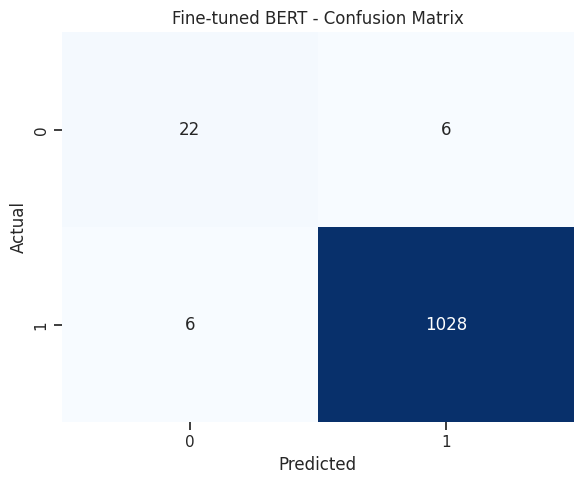

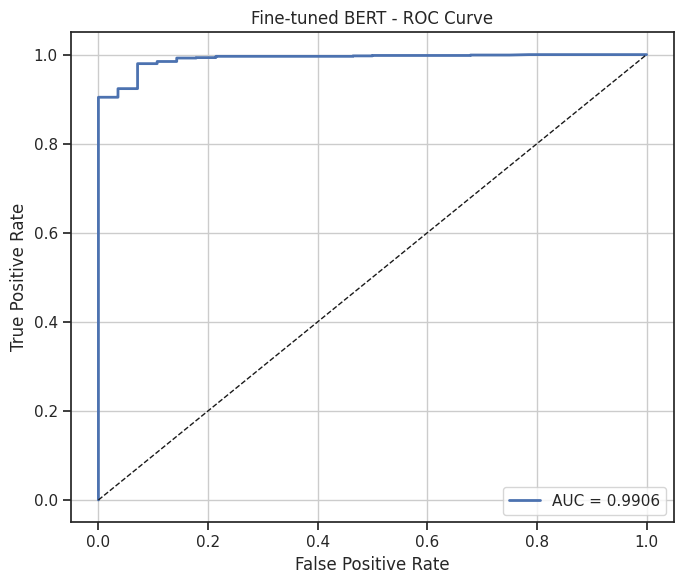

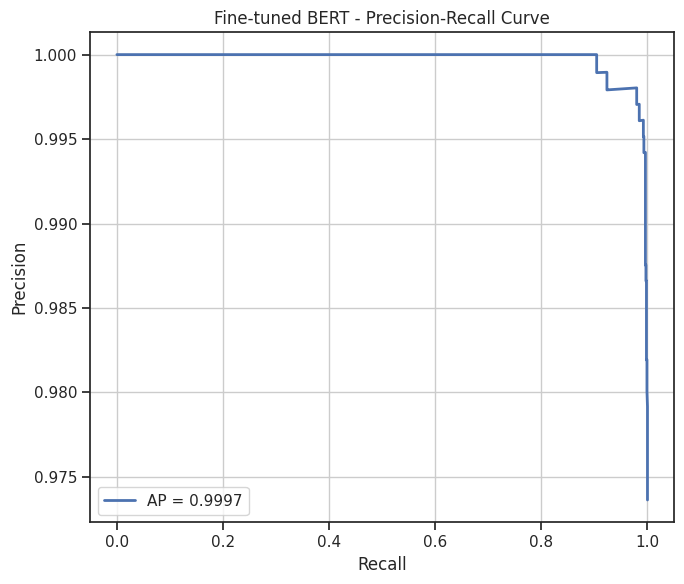

Fine-tuned BERT - ROC AUC Score: 0.9906
Fine-tuned BERT - PR AUC Score: 0.9997


In [48]:
# Run prediction
pred_output = trainer.predict(val_dataset)
y_pred = np.argmax(pred_output.predictions, axis=1)
y_true = val_dataset["labels"]

def evaluate_bert_predictions(y_true, logits, title_prefix="BERT"):
    """
    Evaluates predictions from a fine-tuned BERT model.
    Includes classification report, confusion matrix, ROC and PR curves.
    """
    # Predicted class labels
    y_pred = np.argmax(logits, axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Get positive class probabilities (for binary classification)
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

    # ROC Curve & AUC
    roc_auc = roc_auc_score(y_true, probs)
    fpr, tpr, _ = roc_curve(y_true, probs)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} - ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Precision-Recall Curve & AUC
    precision, recall, _ = precision_recall_curve(y_true, probs)
    pr_auc = average_precision_score(y_true, probs)
    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, label=f"AP = {pr_auc:.4f}", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} - Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"{title_prefix} - ROC AUC Score: {roc_auc:.4f}")
    print(f"{title_prefix} - PR AUC Score: {pr_auc:.4f}")


pred_output = trainer.predict(val_dataset)
y_true = val_dataset["labels"]
logits = pred_output.predictions

evaluate_bert_predictions(y_true, logits, title_prefix="Fine-tuned BERT")

#### Evaluation and Interpretation of Fine-Tuned BERT

- Strong overall accuracy (98.87%) shows the model predicts the sentiment correctly most of the time.

- **For the minority class (0), precision and recall are both about 78.57%, meaning the model correctly identifies around 79% of actual negatives and, when it predicts negative, it’s right nearly 79% of the time. This is solid but not perfect there’s still room to reduce errors on this underrepresented class.**

- For the majority class (1), precision, recall, and F1 are extremely high (99.42%), so it almost always correctly classifies positive reviews and rarely misses them.

- The confusion matrix reveals that out of 28 true negatives, the model correctly identifies 22 (TN), but misclassifies 6 as positives (FP). Similarly, it correctly identifies 1028 positives (TP) but misses 6 (FN).

- The ROC AUC of 0.9906 indicates excellent overall discrimination ability between classes - the model ranks positive instances higher than negatives with high confidence.

- The PR AUC of 0.9997 confirms outstanding performance especially when focusing on the positive class, showing the model keeps a very good balance between precision and recall.

**In short, this fine-tuned BERT model is highly effective, especially on the dominant class, and handles the imbalanced data reasonably well with good minority class detection, though some misclassifications remain on the smaller class.**

#### Sentiment Classification – Model Performance Comparison

To evaluate the effectiveness of different classification strategies, compared three traditional were compared machine learning classifiers trained on BERT sentence embeddings with a fine-tuned BERT transformer model. The results are summarized below:

| Model                               | Accuracy (%) | F1-Score (Label=1) (%) | Precision (0) (%) | Recall (0) (%) | F1-Score (0) (%) |
|-------------------------------------|--------------|-------------------------|--------------------|----------------|------------------|
| **Logistic Regression + BERT Embeddings** | 94.71        | 97.22                  | 31.03              | **84.84**       | 45.44           |
| **SVM + BERT Embeddings**                | 96.55        | 98.21                  | **40.57**          | 68.20          | **50.70**       |
| **XGBoost + BERT Embeddings**            | 93.63        | 96.64                  | 26.84              | 83.33          | 40.58           |
| **Fine-Tuned BERT**                      | **98.87**     | **99.42**               | **78.57**          | **78.57**       | **78.57**       |

##### Validity and Evaluation Checks

- **Balanced Evaluation Metrics:** Each model was evaluated using accuracy and F1-score for both positive (label=1) and negative (label=0) classes to ensure fair comparison across imbalanced classes.
- **Consistent Splits:** All models were trained and evaluated using the same train-test split (80/20), stratified by sentiment label.
- **Embeddings Consistency:** BERT [CLS] pooled embeddings were used as input for all traditional classifiers to ensure a consistent and strong feature representation.
- **No Data Leakage:** Embeddings were computed only on the training set and applied on the test set separately to prevent test data from influencing model training.
- **Random Seeds:** Fixed random seeds (random_state=42) were used across all classifiers to ensure reproducibility.
- **Oversampling Strategy:** SMOTE was applied only to the training set for traditional models to balance classes without leaking synthetic data into evaluation.

##### Interpretation:

- **The fine-tuned BERT model significantly outperforms all traditional classifiers in overall accuracy and balanced F1-scores, especially for the minority class (0).**
- **SVM with BERT embeddings provides the best performance among traditional models, with a good balance between precision and recall for the negative class.**
- Traditional models struggle with precision for class 0, highlighting the difficulty of learning the minority class decision boundary without deep contextual understanding.
- Fine-tuning the BERT transformer allows it to capture subtle semantic and sentiment nuances directly from raw text, leading to substantial performance gains.
- Fine-tuning transformer-based models requires GPU acceleration, longer training times, and greater resource allocation compared to classical machine learning approaches using pre-computed embeddings.

---